# Monsoon CreditTech Assignemnt

## Library Imports

In [1]:
### Data handling libraries
import pandas as pd
import numpy as np

### data visualisation libraries
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from IPython.display import display
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


### scaling
from sklearn.preprocessing import StandardScaler, RobustScaler


### feature engineering libraries
from pandas.api.types import is_string_dtype, is_numeric_dtype


### modelling libraries
from sklearn.linear_model import LogisticRegression



### model tuning, cross validation
from sklearn.model_selection import KFold, GridSearchCV, train_test_split, StratifiedKFold


### performance metric libraries
from sklearn.metrics import (
    roc_curve, auc, classification_report, accuracy_score, confusion_matrix,
    roc_auc_score
  )


## Useful Utility functions

In [2]:
def find_missing_perc(df, columns_missing_values):
    missing_perc_df_list = []
    for c in columns_missing_values:
        missing_perc_df_list.append(pd.DataFrame(df[c].isna().value_counts(normalize=True) * 100)
        .reset_index().rename(columns={c: c+ ' %', 'index':'is_missing'}))
        missing_perc_df_list.append(pd.DataFrame(df[c].isna().value_counts())
        .reset_index().rename(columns={c: c+ ' Count', 'index':'is_missing'}))
    missing_perc_df = pd.concat(missing_perc_df_list, axis=1)
    missing_perc_df = missing_perc_df.loc[:,~missing_perc_df.columns.duplicated()].T
    return missing_perc_df


def find_possible_cat_cont_cols(df, unique_count_thresh=10) : 
    cont_cols = df.columns[df.nunique() > unique_count_thresh].tolist()
    cat_cols = df.columns[df.nunique() <= unique_count_thresh].tolist()
    return cat_cols, cont_cols


def IQR_method(series):
    q1, median, q3 = np.percentile(series, [25, 50, 75])
    iqr = q3 - q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)

    return pd.Series((series < lower_bound) | (series > upper_bound)) 


def Z_method(series, std_threshold=3): 
    mean = np.mean(series)
    std = np.std(series)
    return pd.Series(((x - mean)/ std ) > std_threshold)


def fix_missing(df, col, name, na_dict):
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict


def plot_auc_plots(model_output_dict, pos_label=1):
    markers = list(Line2D.markers.keys())
    plt.figure(figsize=(5, 5), dpi=100)
    for i, model_name in enumerate(model_output_dict.keys()):
        model_results = model_output_dict[model_name]

        fpr, tpr, threshold = roc_curve(model_results['y'],
                                    model_results['y_pred'],
                                    pos_label=pos_label)
        auc_score = auc(fpr, tpr)
        model_results['fpr'] = fpr
        model_results['tpr'] = tpr
        model_results['auc_score'] = auc_score


        plt.plot(fpr, tpr, marker=markers[i],
                 label=f'{model_name} (auc = %0.3f)' % auc_score)

    plt.xlabel('False Positive Rate -->')
    plt.ylabel('True Positive Rate -->')
    plt.legend()
    plt.show()
find_na_cols = lambda data: data.columns[data.isna().any()].tolist()

## Loading the Data 

In [3]:
filename = 'train_flag.csv'
df_train_flag_details = pd.read_csv(filename)

In [4]:
import json
with open('accounts_data_train.json') as f:
    accounts_train_data = json.load(f)

with open('enquiry_data_train.json') as f:
    enquiry_train_data = json.load(f)

# df_accounts_data_train = pd.DataFrame(data)

In [5]:
def from_json_dump_to_df(data) :
    flatten_data = []
    for l in data:
        flatten_data += l 
    return pd.DataFrame(flatten_data)


In [6]:
df_accounts_train = from_json_dump_to_df(accounts_train_data)
df_enquiry_train = from_json_dump_to_df(enquiry_train_data)

In [7]:
import json
with open('accounts_data_test.json') as f:
    accounts_train_data = json.load(f)

with open('enquiry_data_test.json') as f:
    enquiry_train_data = json.load(f)

filename = 'test_flag.csv'
df_test_flag_details = pd.read_csv(filename)

df_accounts_test = from_json_dump_to_df(accounts_train_data)
df_enquiry_test = from_json_dump_to_df(enquiry_train_data)
# df_accounts_data_train = pd.DataFrame(data)

In [8]:
df_train_flag_details.head()

,uid,NAME_CONTRACT_TYPE,TARGET
0,XDA69787158,Cash loans,0
1,BSE47789733,Cash loans,0
2,NTJ92213825,Cash loans,0
3,TCQ47571695,Cash loans,0
4,WJZ68772744,Cash loans,0


In [9]:
df_accounts_train.head(10)

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915
5,Consumer credit,46696.500,0.0,2016-11-20,2017-10-06,000000000000000000000000000000,AAA20326915
6,Credit card,0.000,0.0,2014-09-10,2018-08-30,0000000000000000000000000000000000000000000000...,AAA20326915
7,Consumer credit,117000.000,0.0,2018-02-04,2018-05-06,000000000,AAA20326915
8,Consumer credit,90000.000,0.0,2020-03-12,2020-04-12,000,AAA20326915
9,Consumer credit,235800.000,0.0,2020-03-29,2020-05-13,000,AAA20326915


In [10]:
df_enquiry_train.head(10)

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248
5,Mortgage,44841,2019-11-03,AAA08065248
6,Revolving loans,364751,2020-02-26,AAA08065248
7,Interbank credit,127618,2020-10-04,AAA08065248
8,Loan for purchase of shares (margin lending),315591,2019-06-12,AAA08065248
9,Revolving loans,169056,2019-03-01,AAA08065248


In [11]:
sample_submission = pd.read_csv('sample_submission.csv')

In [12]:
sample_submission.head()

,uid,pred
0,CMO22835242,0.1
1,MRJ34316727,0.1
2,UAV00534378,0.1
3,IPQ08190402,0.1
4,NQN84331006,0.1


In [13]:
df_dict = {
    'accounts_df' : df_accounts_train,
    'enquiry_df' : df_enquiry_train,
    'flag_df' : df_train_flag_details
}

acc='accounts_df'
enq='enquiry_df'
flg='flag_df'

In [14]:
df_test_dict = {
    'accounts_df' : df_accounts_test,
    'enquiry_df' : df_enquiry_test,
    'flag_df' : df_test_flag_details
}

acc='accounts_df'
enq='enquiry_df'
flg='flag_df'

## Exploratory Data Analysis

### Summary: 

Analysis were majorly focused finding useful features that can be converted from
row form to column. 

EDA was performed to understand how we can generate more features.

### Flag Data
This contains details of the loan provided by your client.

In [84]:
data_all = df_dict[flg]
data_all.shape

(261383, 3)

In [85]:
data_all.info(memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261383 entries, 0 to 261382
Data columns (total 3 columns):
uid                   261383 non-null object
NAME_CONTRACT_TYPE    261383 non-null object
TARGET                261383 non-null int64
dtypes: int64(1), object(2)
memory usage: 6.0+ MB


In [86]:
target_variable = 'TARGET'

In [88]:
poss_cat_cols, poss_cont_cols = find_possible_cat_cont_cols(data_all)
poss_cat_cols, poss_cont_cols

(['NAME_CONTRACT_TYPE', 'TARGET'], ['uid'])

#### Univariate Analysis.

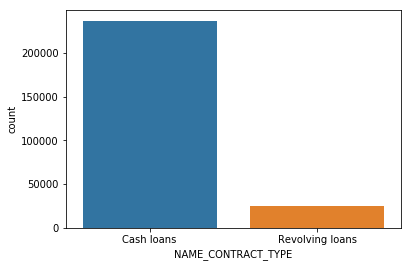

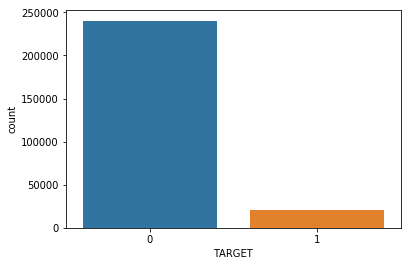

In [90]:
for c in poss_cat_cols: 
  sns.countplot(data_all[c])
  plt.show()

In [96]:
data_all[target_variable].value_counts()

0    240326
1     21057
Name: TARGET, dtype: int64

In [95]:
data_all[target_variable].value_counts(normalize=True) * 100

0    91.944006
1     8.055994
Name: TARGET, dtype: float64

Pointers: 
This is an imbalanced data set as the number of bad loans given is very less compared to the good loans given.

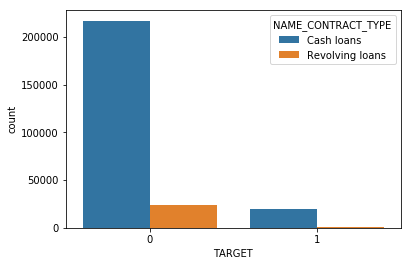

In [91]:
sns.countplot(x=target_variable, hue='NAME_CONTRACT_TYPE', data=data_all)


In [101]:
data_all.groupby([target_variable, 'NAME_CONTRACT_TYPE']).count().reset_index()

,TARGET,NAME_CONTRACT_TYPE,uid
0,0,Cash loans,216823
1,0,Revolving loans,23503
2,1,Cash loans,19701
3,1,Revolving loans,1356


### Accounts data

Details of loans taken by the borrower before they applied for a loan from your client. These details were collected when the borrower applied for a loan from your client.

In [103]:
data_all = df_dict[acc]

#### Checking for the Missing Data

In [281]:
data_all.isna().sum()

credit_type                 0
loan_amount                 3
amount_overdue              0
open_date                   0
closed_date            463035
payment_hist_string         0
uid                         0
dtype: int64

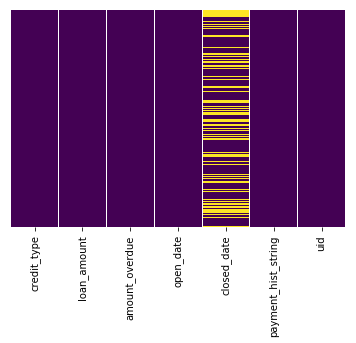

In [206]:
sns.heatmap(data_all.isna(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

In [207]:
## features where there are null values present
dqi_cols = find_na_cols(data_all)
print(len(dqi_cols))
find_missing_perc(data_all, dqi_cols)

2


,0,1
is_missing,False,True
loan_amount %,99.9998,0.000240904
loan_amount Count,1245307,3
closed_date %,62.8177,37.1823
closed_date Count,782275,463035


##### Categorizing/finding type of missing Data

Missing data can be categorized three types. 
1. MCAR - Missing completely at Random
No relationship with Other variables
2. MAR - Missing at Random
There is some relation between other variables (some pattern observed)
3. MNAR - Missing Not at Random 
There is some pattern observed within the same variable

Dropping MCAR type data wouldn't affect the performance as they are missing randomly.

Dropping MAR or MNAR may introduce bias in the data. Dropping missing values is generally not recommended in such cases. 

But again it depends on different scenarios like amount of data and quality of data.

##### Missing data: Loan Amount

Very hard to say why the data was missing since the number of missing values is low.
3 vals. 
it can imputed with either median or dropped(if no rows are available). 
Type: MCAR.

This will be handled while cleaning up the data and feature generation section

Distribution of loan_amount

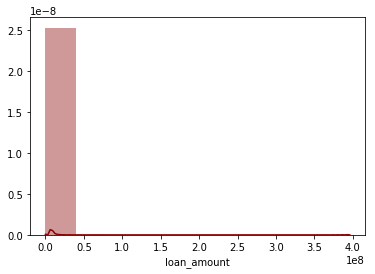

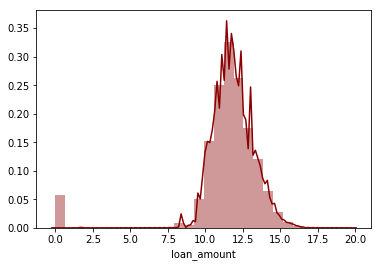

In [284]:
for c in dqi_cols[:1]: 
  sns.distplot(data_all[c].dropna(), color='darkred', bins=10)
  plt.show()
  sns.distplot(np.log1p(data_all[c].dropna()), color='darkred', bins=30)


In [ ]:
temp_data = data_all.merge(df_dict[flg], on='uid')
display(temp_data[temp_data[target_variable]==0].describe())
display(temp_data[temp_data[target_variable]==1].describe())

,loan_amount,amount_overdue,TARGET
count,1.147785e+06,1.147788e+06,1147788.0
mean,3.557825e+05,3.021842e+01,0.0
std,1.138366e+06,6.304366e+03,0.0
min,0.000000e+00,0.000000e+00,0.0
25%,5.166000e+04,0.000000e+00,0.0
50%,1.251630e+05,0.000000e+00,0.0
75%,3.100122e+05,0.000000e+00,0.0
max,3.960000e+08,3.756681e+06,0.0


,loan_amount,amount_overdue,TARGET
count,9.752200e+04,9.752200e+04,97522.0
mean,3.120038e+05,1.809558e+02,1.0
std,6.887391e+05,1.000392e+04,0.0
min,0.000000e+00,0.000000e+00,1.0
25%,4.554000e+04,0.000000e+00,1.0
50%,1.200292e+05,0.000000e+00,1.0
75%,3.013890e+05,0.000000e+00,1.0
max,3.519000e+07,2.387232e+06,1.0


In [198]:
loan_missing = data_all['loan_amount'].isna()
missing_uid_list = data_all[loan_missing].uid

In [203]:
temp_data[temp_data.uid.isin(missing_uid_list)].dropna().groupby('uid').describe()

loan_amount                                                   \
                  count        mean           std        min         25%   
uid                                                                        
BJV01354901         3.0   423805.56  6.151847e+05    55665.0    68708.34   
MVG95017452         5.0  3477220.20  3.170154e+06  1255500.0  1800000.00   

                                               amount_overdue       ...       \
                    50%         75%        max          count mean  ...  75%   
uid                                                                 ...        
BJV01354901    81751.68   607875.84  1134000.0            3.0  0.0  ...  0.0   
MVG95017452  2103660.00  3226941.00  9000000.0            5.0  0.0  ...  0.0   

                 TARGET                                     
             max  count mean  std  min  25%  50%  75%  max  
uid                                                         
BJV01354901  0.0    3.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  
MVG95017452  0.0    5.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  

[2 rows x 24 columns]

##### Missing data: Closed Date
Given per Description: 
Date on which the loan was closed. If the loan is running, then this is missing.

Type: MNAR (missing not at random) 
Phew! the description made it easy :)

For this we can add following features.
1. number of running loans
2. if present time taken to repay
3. average number of next loan taken
4. Other date related features
 
This will be done in data cleaning the data and feature generation section

#### Finding Outliers or curruption in the data.



#### check for corrupted data 
1. len of payment_hist_string is not a multiple of 3 or is equal to zero
2. open_date is stricly >= closed_date
3. check for other possibilities


In [280]:
# rename_column_dict = {
#     c: c + ' IQR Outler' for c in poss_cont_cols
# }
# iqr_outlier_df = data_all[poss_cont_cols].apply(IQR_method).rename(columns=rename_column_dict)

#### Analyis of Accounts Data

creating temproary data frames (it will be does seperately as part of sklearn pipeline) 
so that we do affect the values. 

In [382]:
temp_data = data_all.merge(df_dict[flg], on='uid')
poss_cat_cols, poss_cont_cols = find_possible_cat_cont_cols(temp_data, unique_count_thresh=20)
poss_cat_cols, poss_cont_cols

(['credit_type', 'NAME_CONTRACT_TYPE', 'TARGET'],
 ['loan_amount',
  'amount_overdue',
  'open_date',
  'closed_date',
  'payment_hist_string',
  'uid'])

In [383]:
temp_data.head()

,credit_type,loan_amount,amount_overdue,open_date,closed_date,payment_hist_string,uid,NAME_CONTRACT_TYPE,TARGET
0,Consumer credit,272745.000,0.0,2018-09-22,2020-02-22,0000000000000000000000100000000000000000000000...,AAA09044550,Cash loans,0
1,Consumer credit,4500.000,0.0,2018-03-08,2019-07-25,000000000000000014044000000000000000000000000000,AAA09044550,Cash loans,0
2,Credit card,80996.445,0.0,2020-06-29,NaN,000000000000000000,AAA10545297,Cash loans,0
3,Consumer credit,43771.500,0.0,2020-06-09,2020-09-09,000000000,AAA14112888,Cash loans,0
4,Credit card,10480.500,0.0,2014-09-10,NaN,0000000000000000000000000000000000000000000000...,AAA20326915,Cash loans,0


In [384]:
#### Adding few additional features

obj2date = lambda  x: pd.to_datetime(x)
temp_data['open_date'] =obj2date(temp_data['open_date'])
temp_data['closed_date'] = obj2date(temp_data['closed_date'])
temp_data['is_loan_open'] = 0 
temp_data['is_loan_open'] = np.where(temp_data['closed_date'].isna(), 1, 0)
temp_data['loan_closed_in_days'] = (temp_data['closed_date'] - temp_data['open_date']).dt.days + 0.00001
temp_data['loan_closed_in_days'] = temp_data['loan_closed_in_days'].fillna(-9999)


In [396]:
temp_data['phs_lenght'] = temp_data['payment_hist_string'].str.len() 
# temp_data['phs_mod3_corrupted'] = np.where(temp_data['phs_lenght'] % 3 != 0 , 1, 0)
temp_data['phs_zero_corrupted'] = np.where(temp_data['phs_lenght'] == 0, 1, 0)

In [478]:
# 'is_loan_open' --> just need count for this

In [406]:
loan_missing = temp_data['loan_amount'].isna()
missing_uid_list = temp_data[loan_missing].uid.unique().tolist()

t = dict(temp_data[temp_data.uid.isin(missing_uid_list)].dropna().groupby('uid')['loan_amount'].median())
default_value=0
for i in missing_uid_list:
    if i not in t.keys():
        t[i] = default_value
for c in t.keys():
    temp_data.loc[(temp_data.uid == c) & (loan_missing) , 'loan_amount'] = t[c]

In [525]:
# temp_data.shape

(1245310, 18)

In [560]:
temp_data['amount_overdue'].describe(percentiles=[.99])
np.percentile(temp_data['amount_overdue'], [90, 99.9, 99.99, 99.995, 99.999])


array([0.00000000e+00, 4.63500000e+02, 5.36375475e+04, 1.10701161e+05,
       7.44710908e+05])

In [520]:
temp_df = temp_data.head(500) 
agg_func = [min, max, 'mean', 'median', 'count']
temp_df['loan_amount_log1p'] = np.log1p(temp_df['amount_overdue'] )
temp_df['amount_overdue_log1p'] = np.log1p(temp_df['amount_overdue'])
cont_cols = ['loan_amount', 'amount_overdue', 'loan_closed_in_days','loan_amount_log1p', 'amount_overdue_log1p']
pivoted_df = temp_df.pivot_table(index='uid', columns=['credit_type'], 
                    values=['loan_amount', 'amount_overdue'], aggfunc=agg_func, margins=True).fillna(0)
pivoted_df.columns = [' '.join(i) for i in pivoted_df.columns]
pivoted_df = pivoted_df.iloc[:-1]
pivoted_df.reset_index(inplace=True)
pivoted_df


,uid,min amount_overdue Car loan,min amount_overdue Consumer credit,min amount_overdue Credit card,min amount_overdue Loan for business development,min amount_overdue Microloan,min amount_overdue Mortgage,min amount_overdue All,min loan_amount Car loan,min loan_amount Consumer credit,...,count amount_overdue Microloan,count amount_overdue Mortgage,count amount_overdue All,count loan_amount Car loan,count loan_amount Consumer credit,count loan_amount Credit card,count loan_amount Loan for business development,count loan_amount Microloan,count loan_amount Mortgage,count loan_amount All
0,AAA09044550,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4500.000,...,0.0,0.0,2,0.0,2.0,0.0,0.0,0.0,0.0,2
1,AAA10545297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,...,0.0,0.0,1,0.0,0.0,1.0,0.0,0.0,0.0,1
2,AAA14112888,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,43771.500,...,0.0,0.0,1,0.0,1.0,0.0,0.0,0.0,0.0,1
3,AAA20326915,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,46620.000,...,0.0,0.0,8,0.0,5.0,3.0,0.0,0.0,0.0,8
4,AAA31604840,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41845.500,...,0.0,0.0,5,0.0,4.0,1.0,0.0,0.0,0.0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81,AAG39505501,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19615.500,...,0.0,0.0,11,0.0,7.0,4.0,0.0,0.0,0.0,11
82,AAG53101511,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2326050.0,49871.700,...,0.0,0.0,12,1.0,9.0,2.0,0.0,0.0,0.0,12
83,AAG53270104,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,15745.635,...,0.0,0.0,5,0.0,4.0,1.0,0.0,0.0,0.0,5
84,AAG60498318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39060.000,...,1.0,0.0,12,0.0,6.0,5.0,0.0,1.0,0.0,12


#####
It is difficult to do the analysis as this data is of long datatype. 
This needs to be converted to wide data type and try to capture most of the features. 
Note: The transformation we are doing now are on the temporary data, 
when were doing the modelling we should be ideally doing it using sklearn pipelines
so that it is easy to apply the transformation using transform step. (not done)


Also there are few currupted data we'll have to see how to handle those as well. 

We need to have one row per customer information that would capture most of the stuff here.

Ideally should have spent time on EDA as well. Which always iterative process.

##### Features using PHS

In [507]:
# s = temp_data['payment_hist_string'][0]

phs_to_numbers= lambda s: [float(s[i:i+3]) + 0.0001  for i in range(0, len(s), 3)]
numbers_to_log1p = lambda n: [np.log1p(i) for i in n]
%time temp_data['phs_to_numbers'] = temp_data['payment_hist_string'].apply(lambda x: phs_to_numbers(x))
%time temp_data['phs_to_log1p'] = temp_data['phs_to_numbers'].apply(lambda x: numbers_to_log1p(x))

# 
# np.log1p()

CPU times: user 10.9 s, sys: 185 ms, total: 11.1 s
Wall time: 11.2 s


In [511]:

phs_to_numbers= lambda s: [float(s[i:i+3]) + 0.0001  for i in range(0, len(s), 3)]
numbers_to_log1p = lambda n: [np.log1p(i) for i in n]
%time temp_data['phs_to_numbers'] = temp_data['payment_hist_string'].apply(lambda x: phs_to_numbers(x))
%time temp_data['phs_to_log1p'] = temp_data['phs_to_numbers'].apply(lambda x: numbers_to_log1p(x))


# temp_data['month_avg_due'] = temp_data['phs_to_numbers'].apply(lambda x: np.mean(x))
# temp_data['month_median_due'] = temp_data['phs_to_numbers'].apply(lambda x: np.median(x))
# temp_data['month_min_due'] = temp_data['phs_to_numbers'].apply(lambda x: np.min(x))
# temp_data['month_max_due'] = temp_data['phs_to_numbers'].apply(lambda x: np.max(x))


# temp_data['month_avg_due_log1p'] = temp_data['phs_to_log1p'].apply(lambda x: np.mean(x))
# temp_data['month_median_due_log1p'] = temp_data['phs_to_log1p'].apply(lambda x: np.median(x))
# temp_data['month_min_due_log1p'] = temp_data['phs_to_log1p'].apply(lambda x: np.min(x))
# temp_data['month_max_due_log1p'] = temp_data['phs_to_log1p'].apply(lambda x: np.max(x))



CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.44 µs


In [440]:
# for c in cont_cols: 
#     sns.distplot(temp_data[c])
#     plt.show()
#     sns.distplot(np.log1p(temp_data[c]))
#     plt.show()

In [ ]:
### Univariate Analysis

In [613]:
# for c in poss_cont_cols: 
#   sns.distplot(df_for_analysis[c])

#   plt.show()

In [614]:
# for c in poss_cat_cols: 
#   sns.countplot(temp_data[c])
#   plt.show()

##### Bivariate analysis

In [609]:
# for c in poss_cat_cols: 
#   sns.countplot(x=target_variable, hue=c, data=df_for_analysis)
#   plt.show()

In [610]:
# sns.countplot(x=target_variable, hue='Class',
#               data=df_for_analysis[iqr_outlier_df['Arrival Delay in Minutes IQR Outler']])
# plt.show()
# sns.countplot(x=target_variable, hue='Class', data=df_for_analysis[iqr_outlier_df['Departure Delay in Minutes IQR Outler']])
# plt.show()

In [611]:
# sns.pairplot(df_for_analysis[poss_cont_cols[-2:]])
# plt.show()

In [612]:
# sns.relplot(x=poss_cont_cols[-2], y=poss_cont_cols[-1], hue='satisfaction', data=df_for_analysis)
# plt.show()

In [615]:
# poss_cat_cols

### Analysis for Enquiry Data
This contains details of previous loan applications made by the applicant. These applications may or may not be successful.


In [299]:
data_enq = df_dict[enq]

In [300]:
data_enq.head()

,enquiry_type,enquiry_amt,enquiry_date,uid
0,Interbank credit,168839,2020-11-08,AAA08065248
1,Mobile operator loan,268392,2020-09-20,AAA08065248
2,Mobile operator loan,36082,2020-06-19,AAA08065248
3,Interbank credit,180467,2019-10-22,AAA08065248
4,Cash loan (non-earmarked),227459,2020-05-24,AAA08065248


In [305]:
data_enq.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1909926 entries, 0 to 1909925
Data columns (total 4 columns):
enquiry_type    object
enquiry_amt     int64
enquiry_date    object
uid             object
dtypes: int64(1), object(3)
memory usage: 58.3+ MB


In [306]:
data_enq.describe()

,enquiry_amt
count,1.909926e+06
mean,1.160423e+05
std,8.207031e+04
min,1.007000e+03
25%,5.600000e+04
50%,1.080000e+05
75%,1.590000e+05
max,4.999950e+05


#### Checking for the Missing Data

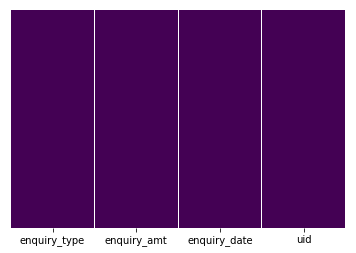

In [307]:
sns.heatmap(data_enq.isna(), yticklabels=False, cbar=False, cmap='viridis')
plt.show()

In [309]:
data_enq.isna().sum()

enquiry_type    0
enquiry_amt     0
enquiry_date    0
uid             0
dtype: int64

##### Nice! 
No missing data in here :) 

In [ ]:
# sns.relplot(x=poss_cat_cols[5], y=poss_cont_cols[-1], hue='satisfaction', data=data_filtered)
# plt.show()

Time is spent more or merging the two data frames and generating features

## Cleaning and Feature Generation: 

1. changing values catagorical values to one hot encoding vectors.
2. dropping id column
3. try different bins for categorical values
4. possibly take log on the skewed data.
5. difference between features. 
6. average of all the ratings.
7. average on the correlated data (flight services, travel services. etc) 
8. Try PCA after generating all the features. 
9. Include outlier flags if it is helpful.

#### Useful Transformers

My plan was to set up a Sklearn pipeline, but because of the time constraint, left this half way. 

In [31]:
from sklearn.base import TransformerMixin


In [32]:
class DFFillLoanMissingTransformer(TransformerMixin):
    def __init__(self, strategy='median', default_value=-1):
        self.strategy = strategy
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        loan_missing = data_all['loan_amount'].isna()
        missing_uid_list = data_all[loan_missing].uid
        t = dict(data_all[data_all.uid.isin(missing_uid_list)].dropna().groupby('uid')['loan_amount'].agg(self.strategy))
        for i in missing_uid_list:
            if i not in t.keys():
                t[i] = self.default_value
        for c in t.keys():
            temp_df.loc[(temp_df.uid == c) & (loan_missing) , 'loan_amount'] = t[c]

#### Converting to required data format

In [33]:
class DFConvertDateObjectToDateFromat(TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        for c in X:
            X.loc[:, c] = pd.to_datetime(X.loc[:, c])
        return X
    
class SimpleCatTransformer(TransformerMixin):
    def __init__(self, default_value=-1):
        self.kv = None
        self.default_value = default_value

    def fit(self, X, y=None):
        columns = X_train.columns.tolist()
        for c in X_train.columns:
            u_list = X_train[c].unique().tolist()
            self.kv[c] = {val: i for i,val in enumerate(u_list)}

        return self

    def transform(self, X):
        return X.apply(lambda x: np.where(x.isin(self.kv[x.name].keys()),
                                          x.map(self. kv[x.name]),
                                          self.default_value).astype(int))
    



#### Feature generation

In [34]:
class Log1pTransformer(TransformerMixin):
    def fit(self, X, y=None): 
        return self
    def transform(self, X): 
        return np.log1p(X)
    
class DummyTransformer(TransformerMixin): 
    def __init__(self): 
        self.dv = None
  
    def fit(self, X, y=None):
        self.dv = DictVectorizer(sparse=False)
        self.dv.fit(X.to_dict('records'))
        return self

    def transform(self, X) : 
        return pd.DataFrame(data=self.dv.transform(X.to_dict('records')),
                        index=X.index,
                        columns=self.dv.get_feature_names())
    
    def predict(self, X) : 
        return pd.DataFrame(data=self.dv.transform(X.to_dict('records')),
                        index=X.index,
                        columns=self.dv.get_feature_names())
    


#### wrapper for supporting DF for skelarn pipeline

In [35]:
from functools import reduce
class ColumnExtractor(TransformerMixin):
    def __init__(self, cols): 
        self.cols = cols
  
    def fit(self, X, y): 
        return self

    def transform(self, X):
        Xcols = X[self.cols]
        return Xcols
    
class DFStandardScaler(TransformerMixin):
    def __init__(self): 
        self.ss = None
  
    def fit(self, X, y=None): 
        self.ss = StandardScaler().fit(X)
        return self
  
    def transform(self, X): 
        return pd.DataFrame(data=self.ss.transform(X), index=X.index,
                        columns=X.columns)
    
class DFFeatureUnion(TransformerMixin):
    # FeatureUnion but for pandas DataFrames

    def __init__(self, transformer_list):
        self.transformer_list = transformer_list

    def fit(self, X, y=None):
        for (name, t) in self.transformer_list:
            t.fit(X, y)
        return self

    def transform(self, X):
      # assumes X is a DataFrame
        Xts = [t.transform(X) for _, t in self.transformer_list]
        Xunion = reduce(lambda X1, X2: pd.merge(X1, X2, left_index=True,
                                              right_index=True), Xts)
        return Xunion


class ZeroFillTransformer(TransformerMixin):
    def fit(self, X, y=None):
      # stateless transformer
        return self

    def transform(self, X):
      # assumes X is a DataFrame
        Xz = X.fillna(value=0)
        return Xz
    
class GroupTransformer(TransformerMixin): 
    def __init__(self, by=None, axis=0, level=None, as_index=True, sort=True, group_keys=True, 
                 observed=False, dropna=True):
        pass
       
    def fit(self, X, y=None): 
        return self
    
    def transform(self, X): 
        return x.groupby(by=self.by, axis=self.axis, level=self.level,as_index=self.sort,
                         sort=True, dropna=True).reset_index()
    
    
    

#### End of Funcs

### From Data - split data into test and train.

In [15]:
df_flag = df_dict[flg].copy()
df_acc = df_dict[acc].copy()
df_enq = df_dict[enq].copy()

In [16]:
target_variable='TARGET'

In [17]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_flag.drop(target_variable, axis=1), df_flag[target_variable],
                                                    stratify=df_flag[target_variable], 
                                                    test_size=0.2)


In [21]:
### Don't peek into test data 


df_flag = df_dict[flg].copy()
df_acc = df_dict[acc].copy()
df_enq = df_dict[enq].copy()

uids_train_list = X_train.uid.unique().tolist()
uids_test_list = X_test.uid.unique().tolist()
filter_rows_uids = lambda uid_list, df: df[df['uid'].isin(uid_list)]
data_dict= {
    'train': {
        'flg_data': X_train,
        'acc_data': filter_rows_uids(uids_train_list, df_acc),
        'enq_data': filter_rows_uids(uids_train_list, df_enq),
        'y': y_train
    },
    'test': {
        'flg_data': X_test,
        'acc_data': filter_rows_uids(uids_test_list, df_acc),
        'enq_data': filter_rows_uids(uids_test_list, df_enq),
        'y': y_test
    }
}


In [19]:
### Don't peek into test data 

df_flag = df_test_dict[flg].copy()
df_acc = df_test_dict[acc].copy()
df_enq = df_test_dict[enq].copy()



uids_test_list = df_flag.uid.unique().tolist()
filter_rows_uids = lambda uid_list, df: df[df['uid'].isin(uid_list)]
data_test_dict= {
    'test': {
        'flg_data': df_flag,
        'acc_data': filter_rows_uids(uids_test_list, df_acc),
        'enq_data': filter_rows_uids(uids_test_list, df_enq),
    }
}



In [663]:
# filter_rows_uids(uids_train_list, df_acc)

In [778]:
# df_acc.head()

#### Setting up Feature Engineering pipeline

#### 1. Basic Features

No complex steps here. 

from account data:
    per uid take the average of loan_amount and amount_overdue
    fill missing values with zero.
    apply standardscaler
    
from enquiry data: 
    per uid take the average of loan amount requested
    
merge: 
    acc_data, enquiry_data
    
Scaled data of the same.

In [20]:
model_data_dict = {}
def get_basic_features(data_dict, acc_cols, enq_cols, key='train', df_flag=df_flag):
    train_data = data_dict[key]
    acc_train = train_data['acc_data'].copy()
    enq_data = train_data['enq_data'].copy()
    acc_train_by_uid = acc_train.groupby('uid')[acc_cols].mean().reset_index()
    enq_train_by_uid = enq_data.groupby('uid')[enq_cols].mean().reset_index()
    
    all_df =  acc_train_by_uid.merge(enq_train_by_uid, on='uid', how='left')\
        .merge(df_flag[['uid', target_variable]], on='uid', how='left')
    return all_df.fillna(0)

acc_cols = ['loan_amount', 'amount_overdue']
enq_cols = ['enquiry_amt']
train_all = get_basic_features(data_dict, acc_cols, enq_cols)
X_train, y_train = train_all.drop(['uid', target_variable], axis=1), train_all[target_variable]

test_all = get_basic_features(data_dict, acc_cols, enq_cols, key='test')
X_test, y_test = test_all.drop(['uid', target_variable], axis=1), test_all[target_variable]

## scale for LR
ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train) 
X_test_scale = ss.transform(X_test)


model_data_dict['basic_features_1'] = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test':y_test
}

model_data_dict['basic_features_scaled_1'] = {
    'X_train': X_train_scale,
    'X_test': X_test_scale,
    'y_train': y_train,
    'y_test':y_test
}

KeyError: "['TARGET'] not in index"

#### 2. Features ( Considering Numeric and Categorical) 

Again: No complex steps here. 

from account data:
    per uid take the average of loan_amount and amount_overdue
    fill missing values with median. 
    apply standardscaler for logistic regression
    
from enquiry data: 
    per uid take the average of loan amount requested
    
merge: 
    acc_data, enquiry_data

In [1034]:
def pivot_table(df, cat_cols, cont_cols, index_col, agg_func, fill_value=0):
    pivoted_df = df.pivot_table(index='uid', columns=cat_cols, 
                    values=cont_cols, aggfunc=agg_func, margins=True).fillna(fill_value)
    pivoted_df.columns = [' '.join(i) for i in pivoted_df.columns]
    pivoted_df = pivoted_df.iloc[:-1]
    pivoted_df.reset_index(inplace=True)
    return pivoted_df

def get_data_features_2(data_dict, acc_cont_cols, acc_cat_cols, enq_cont_cols,
                       enq_cat_cols, key='train', agg_func=None, df_flag=df_flag,
                       fill_method='median', columns=None):

    train_data = data_dict[key]
    acc_data = train_data['acc_data'].copy()
    enq_data = train_data['enq_data'].copy()
    
    pivot_acc_df = pivot_table(acc_data, acc_cat_cols, acc_cont_cols, 'uid', agg_func)
    pivot_enq_df = pivot_table(enq_data, enq_cat_cols, enq_cont_cols, 'uid', agg_func)

    all_df =  pivot_acc_df.merge(pivot_enq_df, on='uid', how='left')\
        .merge(df_flag[['uid', target_variable]], on='uid', how='left')
    
    if key=='test': 
        for c in columns: 
            if c not in all_df.columns:
                all_df[c] = 0
        all_df = all_df[columns]
    return all_df.fillna(0)


acc_cont_cols = ['loan_amount', 'amount_overdue']
acc_cat_cols = ['credit_type']

enq_cont_cols = ['enquiry_amt']
enq_cat_cols = ['enquiry_type']

agg_func = ['mean', 'median']

train_all = get_data_features_2(data_dict, acc_cont_cols, acc_cat_cols, enq_cont_cols,
                       enq_cat_cols, key='train', agg_func=agg_func, df_flag=df_flag,
                       fill_method='median')
X_train, y_train = train_all.drop(['uid', target_variable], axis=1), train_all[target_variable]

test_all = get_data_features_2(data_dict, acc_cont_cols, acc_cat_cols, enq_cont_cols,
                       enq_cat_cols, key='test', agg_func=agg_func, df_flag=df_flag,
                       fill_method='median', columns=train_all.columns.tolist())
X_test, y_test = test_all.drop(['uid', target_variable], axis=1), test_all[target_variable]

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]
assert X_train.shape[1] == X_test.shape[1]

model_data_dict['features_2'] = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test':y_test
}

ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train) 
X_test_scale = ss.transform(X_test)

model_data_dict['features_2_scaled'] = {
    'X_train': X_train_scale,
    'X_test': X_test_scale,
    'y_train': y_train,
    'y_test':y_test
}

In [843]:
import pickle
## saving the data just in case the kernel dies
pickle.dump(model_data_dict, open('model_data_dict_2_scaled.pkl', 'wb')) 

#### 3. Features ( Considering Numeric and Categorical + adding additional features ) 

Again: No complex steps here. 

from account data:
    1. per uid take the average of loan_amount and amount_overdue
    2. add additional features like  log1p mean, min, max, median, loan paid or not, time taken to repay,
    3. count of each is loan_closed, loan_opened. 
    4. finding corrupt data and dropping it
     

from enquiry data: 
    per uid take the average of loan amount requested
    
merge: 
    acc_data, enquiry_data

In [36]:
## Not sure if this will be of good use
def add_datepart(df, fldname, drop=True):
    fld = df[fldname]
    if not np.issubdtype(fld.dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    for n in ('Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start'):
        df[targ_pre+n] = getattr(fld.dt,n.lower())
    df[targ_pre+'Elapsed'] = fld.astype(np.int64) // 10**9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [37]:
from sklearn.feature_extraction import DictVectorizer

def add_date_features(df, sd_col, ed_col):
    df[sd_col] = pd.to_datetime(df[sd_col])
    df[ed_col] = pd.to_datetime(df[ed_col])
    df['loan_open'] = np.where(df[ed_col].isna(), 1, 0)
    df['loan_closed'] = np.where(~df[ed_col].isna(), 1, 0)
    df['time_taken_pay'] = (df[ed_col] - df[sd_col]).dt.days
    df['time_taken_pay'].fillna(99999, inplace=True)
    df['date_corrupted_records'] = df[ed_col] < df[sd_col]
    return df.drop([sd_col, ed_col], axis=1)

def add_payment_hist_string_features(df, col):
    phs_to_numbers= lambda s: [float(s[i:i+3])  for i in range(0, len(s), 3)]
    numbers_to_log1p = lambda n: [np.log1p(i) for i in n]
    df['installements'] = df['payment_hist_string'].str.len() / 3.0
    df['phs_days_overdue'] = df['payment_hist_string'].apply(lambda x: np.sum(phs_to_numbers(x)))
    df['phs_days_overdue_log1p'] = df['phs_days_overdue'].apply(lambda x: np.sum(np.log1p(x)))
    df['phs_corrupted'] = np.where(df['installements'] == 0, 1, 0)
    df['phs_days_overdue_avg'] = df['phs_days_overdue'] / ( df['installements'] + df['phs_corrupted'] ) 
    df['phs_days_overdue_log1p_avg'] = df['phs_days_overdue_log1p'] / df['installements']
    return df.drop(col, axis=1)

def add_log1p_features(df, cols):
    for c in cols:
        df[c+'_log1p'] = np.log1p(df[c])
    return df

def bin_numerical_data(df, cols, bin_dict): 
    binned_cols = []
    for c in cols: 
        df[c+'_bin'] = pd.cut(df[c], bin_dict[c])\
            .apply(lambda x: f'_{x.right}')
        binned_cols.append(c+'_bin')
    return df, binned_cols

def add_dummy_1(df, col='dummy') : 
    df[col] = 1
    return df 

def add_cat_dummies(df, cols, dt=None):
    if not dt:
        dt = DummyTransformer()
        temp_df = dt.fit_transform(df[cols])
        return dt, temp_df
    else: 
        return dt, dt.transform(df[cols])


In [38]:
def enq_get_agg_func():
    agg_func={
    'enquiry_amt': [np.mean, np.median, min, max],
    'enquiry_amt_log1p': [np.mean, np.median],
    'enq' : [np.sum ]
    }
    return agg_func

def get_enq_features_3(enq_data):
    enq_data = add_log1p_features(enq_data, ['enquiry_amt'])
    enq_data = add_dummy_1(enq_data, col='enq')
    agg_func = enq_get_agg_func()
    features_all = enq_data.groupby(['uid', 'enquiry_type']).agg(agg_func)
    assert features_all.isna().sum().sum() == 0 
    cols = [' '.join(i) for i in features_all.columns]
    features_all.columns = cols
    
    features_all = features_all.reset_index().pivot_table(index='uid', columns='enquiry_type',
                                                          values=cols)
    features_all.columns = [' '.join(i) for i in features_all.columns]
    features_all = features_all.fillna(0).reset_index()
    return features_all

In [39]:
def acc_get_agg_func(binned_cols):
    agg_func={
    'loan_amount': [np.mean, np.median, min, max],
    'amount_overdue': [np.mean, np.median],
    'loan_open' : [np.sum ],
    'loan_closed': [np.sum],
    'time_taken_pay': [np.mean],
    'installements': [np.mean, np.median],
    'phs_days_overdue':  [np.max, np.mean, np.median],
    'phs_days_overdue_log1p': [np.max, np.mean, np.median],
    'phs_days_overdue_avg': [np.mean],
    'phs_days_overdue_log1p_avg': [np.mean],
    'loan_amount_log1p': [np.mean],
    'amount_overdue_log1p': [np.mean],
    'dummy': [np.sum]    
    }
    agg_func.update({b: [np.sum] for b in binned_cols})
    return agg_func

def get_acc_features_3(acc_data, dt=None, key='train'):

    sd_col, ed_col= 'open_date', 'closed_date'
    phs_col = 'payment_hist_string'
    bin_dict = {
        'amount_overdue': [-1, 1 , 100, 10000, 1000000,100000000]
    }
    acc_data = add_date_features(acc_data,  sd_col, ed_col) 
    acc_data = add_payment_hist_string_features(acc_data, phs_col)
    acc_data = add_log1p_features(acc_data, ['loan_amount', 'amount_overdue'])
    acc_data, binned_cols = bin_numerical_data(acc_data,['amount_overdue'], bin_dict)
   
    if key == 'train' :
        dt = DummyTransformer()
        dummied_data =dt.fit_transform(acc_data[binned_cols])
    else: 
        dummied_data =dt.transform(acc_data[binned_cols])
    
    binned_cols_ = dummied_data.columns.tolist()
    features_all =pd.concat([acc_data, dummied_data], axis=1)
    features_all = add_dummy_1(features_all) 
    
    features_all = features_all[~features_all['loan_amount'].isna()]
    features_all = features_all[features_all['phs_corrupted'] == 0]
    features_all = features_all[features_all['phs_corrupted'] == 0]
    # return features_all, ''
    assert features_all.isna().sum().sum() == 0
    to_remove = ['date_corrupted_records', 'phs_corrupted', 'amount_overdue_bin']
    features_all.drop(to_remove, axis=1, inplace=True)
    
    agg_func= acc_get_agg_func(binned_cols_)
    features_all = features_all.groupby(['uid', 'credit_type']).agg(agg_func)
    cols = [' '.join(i) for i in features_all.columns]
    features_all.columns = cols
    features_all = features_all.reset_index().pivot_table(index='uid', columns='credit_type', values=cols)
    features_all.columns = [' '.join(i) for i in features_all.columns]
    acc_features_all = features_all.fillna(0).reset_index()
    return acc_features_all, dt

In [40]:
def get_feature_3(data_dict, key='train', columns=None, dt=None, dt_flg=None, df_flag=df_train_flag_details):
    acc_data = data_dict[key]['acc_data']
    enq_data = data_dict[key]['enq_data']
    
    acc_features_all, dt = get_acc_features_3(acc_data.copy(), dt=dt, key=key)
    enq_feature_all = get_enq_features_3(enq_data.copy())
    
    
    if key == 'train' :
        dt_flg = DummyTransformer()
        dummied_data = dt_flg.fit_transform(df_flag[['NAME_CONTRACT_TYPE']])
    else: 
        dummied_data = dt_flg.transform(df_flag[['NAME_CONTRACT_TYPE']])
        
    flg_data = pd.concat([df_flag, dummied_data], axis=1).drop('NAME_CONTRACT_TYPE', axis=1)
    all_df =  acc_features_all.merge(enq_feature_all, on='uid', how='left')\
        .merge(flg_data, on='uid', how='left')
    if key=='test': 
        for c in columns: 
            if c not in all_df.columns:
                all_df[c] = 0
        all_df = all_df[columns]
    return all_df, dt, dt_flg
    # acc_features_test_all, _ = get_acc_features_3(data_dict['test']['acc_data'].copy(), dt)
    # enq_feature_test_all = get_enq_features_3(data_dict['test']['enq_data'].copy())

In [41]:
# df_flag.head()

In [42]:
train_all, acc_dt, flg_dt = get_feature_3(data_dict, key='train', columns=None, dt=None, dt_flg=None, 
                                          df_flag=df_train_flag_details)
test_all, _, _ = get_feature_3(data_dict, key='test', columns=train_all.columns, dt=acc_dt, dt_flg=flg_dt,
                               df_flag=df_train_flag_details)
X_train, y_train = train_all.drop(['uid', target_variable], axis=1), train_all[target_variable]

X_test, y_test = test_all.drop(['uid', target_variable], axis=1), test_all[target_variable]

assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]
assert X_train.shape[1] == X_test.shape[1]

model_data_dict['features_3'] = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test':y_test
}

ss = StandardScaler()
X_train_scale = ss.fit_transform(X_train) 
X_test_scale = ss.transform(X_test)

model_data_dict['features_3_scaled'] = {
    'X_train': X_train_scale,
    'X_test': X_test_scale,
    'y_train': y_train,
    'y_test':y_test
}

#### Creating main Test data features

In [43]:
test_all, _, _ = get_feature_3(data_dict, key='test', columns=train_all.columns, dt=acc_dt, dt_flg=flg_dt,
                               df_flag=df_flag)
X_train = test_all.drop(['uid'], axis=1)


model_data_dict['main_X_test'] = {
    'X_test': X_test,
    'uid_col': test_all[['uid']]

}

X_test_scale = ss.transform(X_test)

model_data_dict['main_X_test_scaled'] = {
    'X_test': X_test_scale,
    'uid_col': test_all[['uid']]
}

In [56]:
model_data_dict.keys()

dict_keys(['features_3', 'features_3_scaled', 'main_X_test', 'main_X_test_scaled'])

In [1]:
import pickle
## saving the data just in case the kernel dies
# pickle.dump(model_data_dict, open('model_data_dict_3_scaled.pkl', 'wb'))

model_data_dict = pickle.load(open('model_data_dict_3_scaled.pkl', 'rb'))

## Modelling

In [707]:
# X_test.isna().sum()

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier

In [185]:




# X_train_input = feature_genearation.fit_transform(X_train, y_train)
# X_test_input = feature_genearation.transform(X_test)
pipes={}

def run_modeling(X_train, y_train, X_test, y_test, estimators=estimators): 
    model_output_dict = {}
    model_output_dict_test = {}

    for model in estimators:
        # pipe=Pipeline(steps=[('data_prep', feature_genearation),model])
        model[1].fit(X_train, y_train)

        model_output_dict[model[0]] = {
            'y' : y_train.astype(int),
            'y_pred': model[1].predict_proba(X_train)[:,0],
        }

        model_output_dict_test[model[0]] = {
            'y' : y_test.astype(int),
            'y_pred': model[1].predict_proba(X_test)[:,0],
        }
        
    plot_auc_plots(model_output_dict_test, pos_label=0)
    return model_output_dict, model_output_dict_test

In [801]:
model_data_dict.keys()

dict_keys(['basic_features_1', 'basic_features_scaled_1', 'features_2', 'features_2_scaled'])

### Modelling with feature set 1

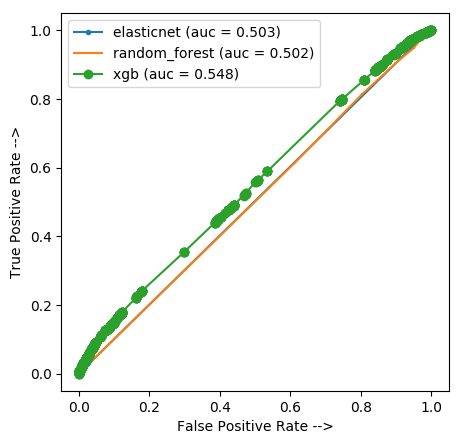

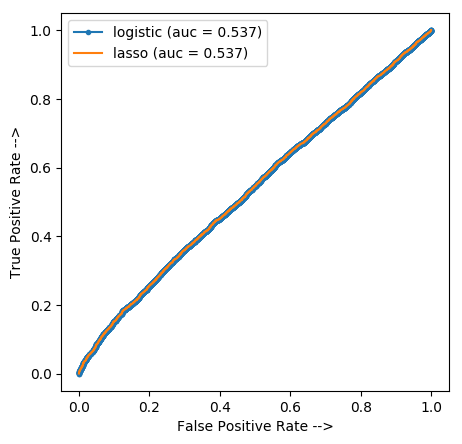

In [826]:
features_key = 'basic_features_1'
model_input_dict = model_data_dict[features_key]

estimators=[
    # ('ridge',RidgeClassifier()),
    ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
    #('decision_tree',DecisionTreeClassifier()),
    ('random_forest',RandomForestClassifier()),
    ('xgb',XGBClassifier(ojective='reg:logistic')),
    # ('svc',LinearSVC()),
    # ('deep_nn',MLPClassifier()),
    # ('knn',KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto'))
]
_ = run_modeling(model_input_dict['X_train'], model_input_dict['y_train'], model_input_dict['X_test'],
                 model_input_dict['y_test'], estimators=estimators)


features_key = 'basic_features_scaled_1'
model_input_dict = model_data_dict[features_key]
estimators=[
    ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
    ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
]

_ = run_modeling(model_input_dict['X_train'], model_input_dict['y_train'], model_input_dict['X_test'],
                 model_input_dict['y_test'], estimators=estimators)

#####
looks like all of the classifiers are doing pretty bad. 
out of all xgb is doing better than any. 

### Modelling with feature set 2

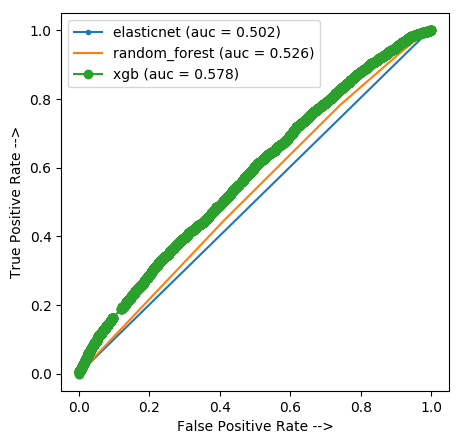

In [833]:
features_key = 'features_2'
model_input_dict = model_data_dict[features_key]

estimators=[
    # ('ridge',RidgeClassifier()),
    ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
    #('decision_tree',DecisionTreeClassifier()),
    ('random_forest',RandomForestClassifier()),
    ('xgb',XGBClassifier(ojective='reg:logistic')),
    # ('svc',LinearSVC()),
    # ('deep_nn',MLPClassifier()),
    # ('knn',KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto'))
]
a, b = run_modeling(model_input_dict['X_train'], model_input_dict['y_train'], model_input_dict['X_test'],
                 model_input_dict['y_test'], estimators=estimators)




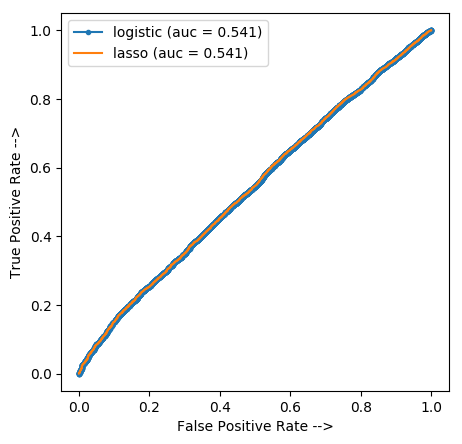

In [838]:
features_key = 'features_2_scaled'
model_input_dict = model_data_dict[features_key]
estimators=[
    ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
    ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
]

c, d = run_modeling(model_input_dict['X_train'], model_input_dict['y_train'], model_input_dict['X_test'],
                 model_input_dict['y_test'], estimators=estimators)

### Modelling with feature set 3

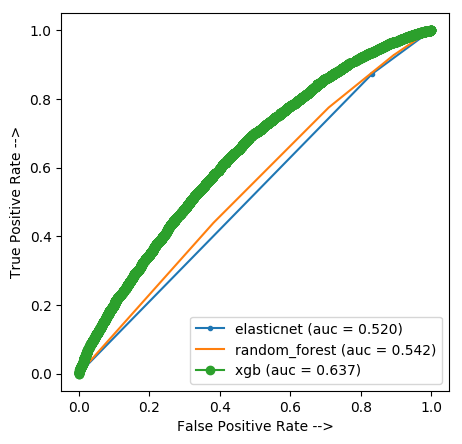

In [1157]:
features_key = 'features_3'
model_input_dict = model_data_dict[features_key]

estimators=[
    # ('ridge',RidgeClassifier()),
    ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
    #('decision_tree',DecisionTreeClassifier()),
    ('random_forest',RandomForestClassifier()),
    ('xgb',XGBClassifier(ojective='reg:logistic')),
    # ('svc',LinearSVC()),
    # ('deep_nn',MLPClassifier()),
    # ('knn',KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto'))
]
a, b = run_modeling(model_input_dict['X_train'], model_input_dict['y_train'], model_input_dict['X_test'],
                 model_input_dict['y_test'], estimators=estimators)




 This was taking lot of time and hence decided to stop it ~2hrs

In [1158]:
features_key = 'features_3_scaled'
model_input_dict = model_data_dict[features_key]
estimators=[
    ('logistic',LogisticRegression(solver='liblinear',penalty='l2')),
    ('lasso',LogisticRegression(solver='liblinear',penalty='l1')),
]

c, d = run_modeling(model_input_dict['X_train'], model_input_dict['y_train'], model_input_dict['X_test'],
                 model_input_dict['y_test'], estimators=estimators)

KeyboardInterrupt: 

In [1159]:
del a, b, c, d


### Try reducing the number of features using PCA

In [1165]:
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score

In [1171]:
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score
features_key = 'features_3_scaled'
model_input_dict = model_data_dict[features_key]
for i in [ 242, 121, 60, 30, 15, 8][::-1]:
    pca = PCA(n_components=i)
    pca.fit(model_input_dict['X_train'])
    X_train_trf =pca.fit_transform(model_input_dict['X_train'])
    X_train_inv = pca.inverse_transform(X_train_trf)
    X_test_trf = pca.transform(model_input_dict['X_test'])
    X_test_inv = pca.inverse_transform(X_test_trf)

    print(i, explained_variance_score(model_input_dict['X_train'], X_train_inv, ),
        explained_variance_score(model_input_dict['X_test'] , X_test_inv ))


8 0.3288386788460792 -5.0007988745582085e+35
15 0.42996629703983363 -8.3218025274183e+35
30 0.5877340641557757 -4.480093699963483e+36
60 0.7729147295701009 -8.27743578324212e+39
121 0.8638188459388462 -8.541995641583777e+39
242 0.895943168721135 -8.554472024291985e+39


In [1173]:
n_components=242
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(model_input_dict['X_train'])
X_test_pca = pca.transform(model_input_dict['X_test'])

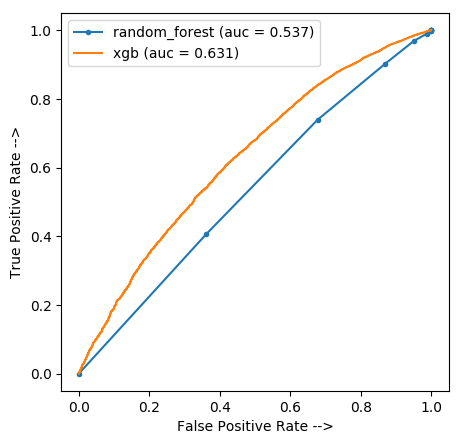

In [1174]:

estimators=[
    # ('ridge',RidgeClassifier()),
    # ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
    #('decision_tree',DecisionTreeClassifier()),
    ('random_forest',RandomForestClassifier()),
    ('xgb',XGBClassifier(ojective='reg:logistic')),
    # ('svc',LinearSVC()),
    # ('deep_nn',MLPClassifier()),
    # ('knn',KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto'))
]
_ = run_modeling(X_train_pca, model_input_dict['y_train'], X_test_pca,
                 model_input_dict['y_test'], estimators=estimators)




### Try Oversampling data

In [72]:
from imblearn.over_sampling import RandomOverSampler
ns = RandomOverSampler(0.5)
X_train_ns, y_train_ns = ns.fit_resample()


estimators=[
    # ('ridge',RidgeClassifier()),
    # ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
    #('decision_tree',DecisionTreeClassifier()),
    ('random_forest',RandomForestClassifier()),
    # ('xgb',XGBClassifier(ojective='reg:logistic')),
    # ('svc',LinearSVC()),
    # ('deep_nn',MLPClassifier()),
    # ('knn',KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto'))
]
_ = run_modeling(X_train_ns, y_train_ns, X_test.values,
                 model_input_dict['y_test'], estimators=estimators)




In [ ]:

estimators=[
    # ('ridge',RidgeClassifier()),
    # ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
    #('decision_tree',DecisionTreeClassifier()),
    ('random_forest',RandomForestClassifier()),
    # ('xgb',XGBClassifier(ojective='reg:logistic')),
    # ('svc',LinearSVC()),
    # ('deep_nn',MLPClassifier()),
    # ('knn',KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto'))
]
_ = run_modeling(X_train_ns, y_train_ns, X_test.values,
                 model_input_dict['y_test'], estimators=estimators)




In [ ]:
del X_train_ns, y_train_ns

plot_auc_plots trying out SMOTE

In [1191]:
from imblearn.combine import SMOTETomek

##@### It got stuck here. Had to restart the kernel

In [ ]:
os = SMOTETomek(0.5)
X_train_sm, y_train_sm = os.fit_resample(X_train, y_train)

In [ ]:

estimators=[
    # ('ridge',RidgeClassifier()),
    # ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
    #('decision_tree',DecisionTreeClassifier()),
    ('random_forest',RandomForestClassifier()),
    ('xgb',XGBClassifier(ojective='reg:logistic')),
    # ('svc',LinearSVC()),
    # ('deep_nn',MLPClassifier()),
    # ('knn',KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto'))
]
_ = run_modeling(X_train_sm, y_train_sm, X_test,
                 model_input_dict['y_test'], estimators=estimators)




In [ ]:
del _

In [ ]:
del X_train, y_train

## Model Tuning

### RFC tuning

In [105]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

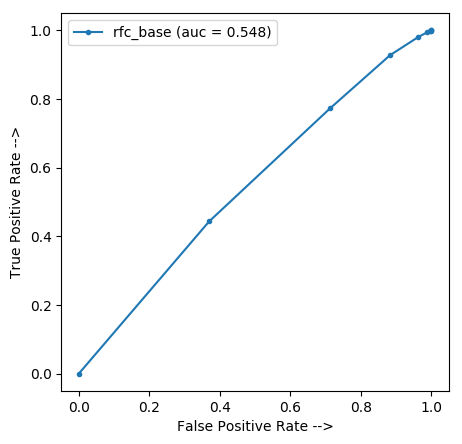

In [87]:
features_key = 'features_3'
model_input_dict = model_data_dict[features_key]

rfc= RandomForestClassifier()

rfc.fit(model_input_dict['X_train'], model_input_dict['y_train'])

y_preds = rfc.predict_proba(model_input_dict['X_test'])

plot_auc_plots({'rfc_base': { 'y': model_input_dict['y_test'], 'y_pred': y_preds[:,0]}}, pos_label=0)
# a, b = run_modeling(model_input_dict['X_train'], model_input_dict['y_train'], model_input_dict['X_test'],
#                  model_input_dict['y_test'], estimators=estimators)




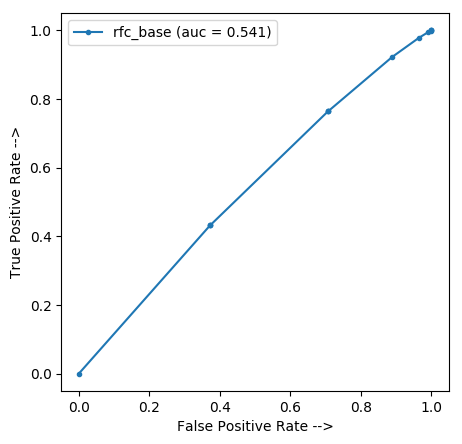

In [120]:
features_key = 'features_3'
model_input_dict = model_data_dict[features_key]

rfc= RandomForestClassifier()

rfc.fit(model_input_dict['X_train'][imp_feats], model_input_dict['y_train'])

y_preds = rfc.predict_proba(model_input_dict['X_test'][imp_feats])

plot_auc_plots({'rfc_base': { 'y': model_input_dict['y_test'], 'y_pred': y_preds[:,0]}}, pos_label=0)
# a, b = run_modeling(model_input_dict['X_train'], model_input_dict['y_train'], model_input_dict['X_test'],
#                  model_input_dict['y_test'], estimators=estimators)




In [67]:
print(roc_auc_score(model_input_dict['y_test'], y_preds[:,1]))

0.5377257838562867


In [126]:
from sklearn.model_selection import KFold,cross_validate
from sklearn.metrics import make_scorer, f1_score, accuracy_score,roc_auc_score,log_loss
_metrics = {'auc':make_scorer(roc_auc_score)}

param_grid= {
 'n_estimators':[10,50,100,150,200,500],
 'max_depth':[3,8,13,18],
'max_leaf_nodes':[5,10,15,20,25]   
}


#### RFC + GridSearch 

In [127]:
rfc_gs=GridSearchCV(rfc,param_grid,scoring=_metrics,refit='auc',cv=5, verbose=1, n_jobs=-1)

In [128]:
rfc_params = rfc_gs.fit(model_input_dict['X_train'], model_input_dict['y_train'])

Fitting 5 folds for each of 120 candidates, totalling 600 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 386 tasks      | elapsed: 10.2min
[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 18.9min finished


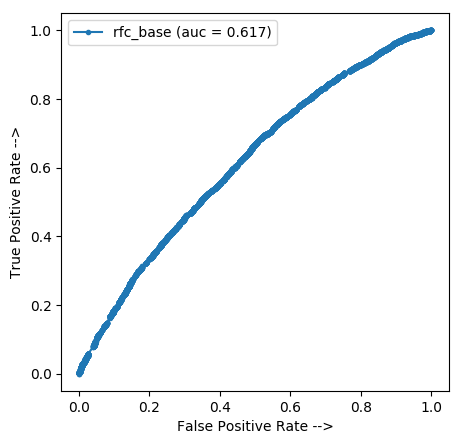

In [145]:
rfc_best = RandomForestClassifier(**rfc_params.best_params_) 
rfc_best.fit(model_input_dict['X_train'], model_input_dict['y_train'])
y_preds = rfc_best.predict_proba(model_input_dict['X_test'])
plot_auc_plots({'rfc_base': { 'y': model_input_dict['y_test'], 'y_pred': y_preds[:,0]}}, pos_label=0)

#### RFC + GridSearch  + overSampler

In [191]:
from imblearn.over_sampling import RandomOverSampler
ns = RandomOverSampler(0.5)
X_train_ns, y_train_ns = ns.fit_resample(model_input_dict['X_train'], model_input_dict['y_train'])

param_grid= {
 'n_estimators':[10,50,100,150,200,500],
 'max_depth':[3,8,13,18],
'max_leaf_nodes':[5,10,15,20,25]   
}

rfc= RandomForestClassifier(n_jobs=16)


rfc_gs=GridSearchCV(rfc,param_grid,scoring=_metrics,refit='auc',cv=2, verbose=1, n_jobs=16)
rfc_params = rfc_gs.fit(X_train_ns, y_train_ns)


Fitting 2 folds for each of 120 candidates, totalling 240 fits


[Parallel(n_jobs=16)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=16)]: Done  18 tasks      | elapsed:   37.4s
[Parallel(n_jobs=16)]: Done 168 tasks      | elapsed:  7.4min
[Parallel(n_jobs=16)]: Done 240 out of 240 | elapsed: 11.4min finished


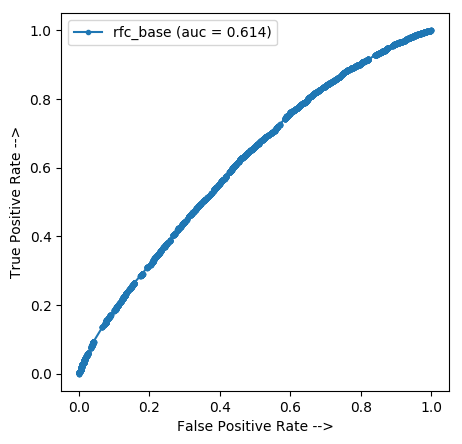

In [192]:
rfc_best = RandomForestClassifier(**rfc_params.best_params_) 
rfc_best.fit(model_input_dict['X_train'], model_input_dict['y_train'])
y_preds = rfc_best.predict_proba(model_input_dict['X_test'])
plot_auc_plots({'rfc_base': { 'y': model_input_dict['y_test'], 'y_pred': y_preds[:,0]}}, pos_label=0)

### Model: LR + Oversampling

In [212]:
ns = RandomOverSampler(0.5)
X_train_ns_scaled, y_train_ns_scaled = ns.fit_resample(model_data_dict['features_3_scaled']['X_train'],
                                         model_data_dict['features_3_scaled']['y_train'])

In [ ]:
lr_model = LogisticRegression(solver='liblinear',penalty='l2', n_jobs=20, verbose=1)
lr_model.fit(X_train_ns_scaled, y_train_ns_scaled)
y_preds = lr_model.predict_proba(model_data_dict['features_3_scaled']['X_test_scaled'])
plot_auc_plots({'lr_base': { 'y': model_input_dict['y_test'], 'y_pred': y_preds[:,0]}}, pos_label=0)

### Model Tuning: XGBoost

Unable to tune the model as it is getting stuck.
Hence going ahead as is

In [87]:
features_key = 'features_3'
model_input_dict = model_data_dict[features_key]
from imblearn.over_sampling import RandomOverSampler
ns = RandomOverSampler(0.5)
X_train_ns, y_train_ns = ns.fit_resample(model_input_dict['X_train'], model_input_dict['y_train'])
xgb = XGBClassifier(ojective='reg:logistic', n_jobs=-1)
xgb.fit(X_train_ns, y_train_ns)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              ojective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

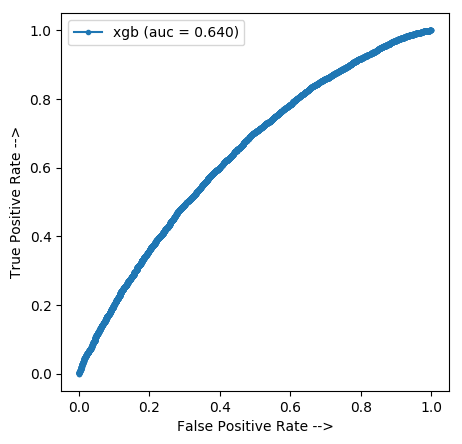

In [88]:
y_preds = xgb.predict_proba(model_input_dict['X_test'].values)
plot_auc_plots({'xgb': { 'y': model_input_dict['y_test'], 'y_pred': y_preds[:,0]}}, pos_label=0)

In [50]:
features_key = 'features_3'
model_input_dict = model_data_dict[features_key]
from imblearn.over_sampling import RandomOverSampler
ns = RandomOverSampler(0.5)
X_train_ns, y_train_ns = ns.fit_resample(model_input_dict['X_train'], model_input_dict['y_train'])
xgb = XGBClassifier(ojective='reg:logistic', n_jobs=-1, n_estimators=500,  max_depth=7)
xgb.fit(X_train_ns, y_train_ns)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=None, n_estimators=500,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              ojective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

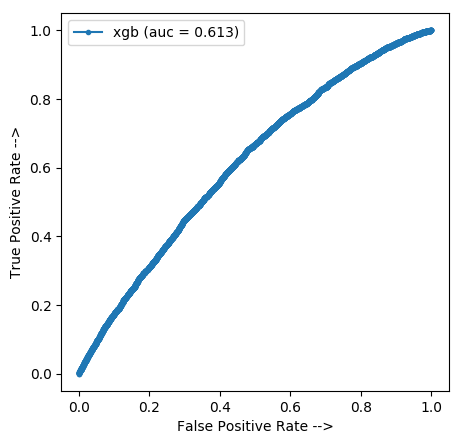

In [77]:
features_key = 'features_3_scaled'
model_input_dict = model_data_dict[features_key]
from imblearn.over_sampling import RandomOverSampler
ns = RandomOverSampler(0.5)
X_train_ns, y_train_ns = ns.fit_resample(model_input_dict['X_train'], model_input_dict['y_train'])
xgb_2 = XGBClassifier(ojective='reg:logistic', n_jobs=-1)
xgb_2.fit(X_train_ns, y_train_ns)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
              n_jobs=-1, nthread=None, objective='binary:logistic',
              ojective='reg:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
              subsample=1)

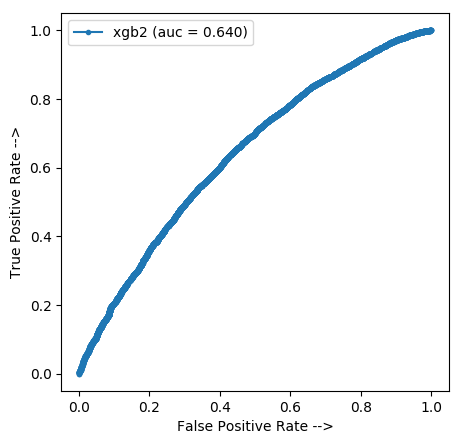

In [80]:
y_preds = xgb_2.predict_proba(model_input_dict['X_test'])
plot_auc_plots({'xgb2': { 'y': model_input_dict['y_test'], 'y_pred': y_preds[:,0]}}, pos_label=0)

In [ ]:
features_key = 'features_3_scaled'
model_input_dict = model_data_dict[features_key]
from imblearn.over_sampling import RandomOverSampler
ns = RandomOverSampler(0.5)
X_train_ns, y_train_ns = ns.fit_resample(model_input_dict['X_train'], model_input_dict['y_train'])
xgb_2 = XGBClassifier(ojective='reg:logistic', n_jobs=-1)
xgb_2.fit(X_train_ns, y_train_ns)

y_preds = xgb_2.predict_proba(model_input_dict['X_test'])
plot_auc_plots({'xgb2': { 'y': model_input_dict['y_test'], 'y_pred': y_preds[:,0]}}, pos_label=0)

In [ ]:
# param_grid={'n_estimators': [100, 500, 900]} 
# xgb_gs = GridSearchCV(xgb,param_grid,scoring=_metrics,refit='auc', n_jobs=-1, cv=2, verbose=3)
# xgb_params = xgb_gs.fit(model_input_dict['X_train'], model_input_dict['y_train'])

In [ ]:
# xgb.set_params(**xgb_gs.best_params_) 
# xgb.set_params(**{'n_jobs': -1})
# xgb.fit(model_input_dict['X_train'], model_input_dict['y_train'])
# y_preds = rfc_best.predict_proba(model_input_dict['X_test'])

In [ ]:
# plot_auc_plots({'xgb_base': { 'y': model_input_dict['y_test'], 'y_pred': y_preds[:,0]}}, pos_label=0)

In [ ]:
# rfc_params.best_params_

In [ ]:
# param_grid={'max_depth':[5,7,9]}
# xgb_gs = GridSearchCV(xgb,param_grid,scoring=_metrics,refit='auc', n_jobs=-1, cv=2, verbose=3)
# xgb_params = xgb_gs.fit(model_input_dict['X_train'], model_input_dict['y_train'])

In [ ]:
# xgb.set_params(**xgb_gs.best_params_) 
# xgb.fit(model_input_dict['X_train'], model_input_dict['y_train'])
# y_preds = rfc_best.predict_proba(model_input_dict['X_test'])
# plot_auc_plots({'rfc_base': { 'y': model_input_dict['y_test'], 'y_pred': y_preds[:,0]}}, pos_label=0)

In [ ]:
# param_grid={'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3]}
# xgb_gs = GridSearchCV(xgb,param_grid,scoring=_metrics,refit='auc', n_jobs=-1, cv=2, verbose=3)
# xgb_params = xgb_gs.fit(model_input_dict['X_train'], model_input_dict['y_train'])

In [197]:
# from imblearn.over_sampling import RandomOverSampler
# ns = RandomOverSampler(0.5)
# X_train_ns, y_train_ns = ns.fit_resample(model_input_dict['X_train'], model_input_dict['y_train'])


# estimators=[
#     # ('ridge',RidgeClassifier()),
#     # ('elasticnet',SGDClassifier(loss='log', penalty='elasticnet')),
#     #('decision_tree',DecisionTreeClassifier()),
#     ('random_forest',RandomForestClassifier(n_jobs=-1)),
#     ('xgb',XGBClassifier(ojective='reg:logistic', n_jobs=-1)),
#     # ('svc',LinearSVC()),
#     # ('deep_nn',MLPClassifier()),
#     # ('knn',KNeighborsClassifier(n_neighbors=5, weights='distance', algorithm='auto'))
# ]
# _ = run_modeling(X_train_ns, y_train_ns, X_test.values,
#                  model_input_dict['y_test'], estimators=estimators)




In [86]:
# from sklearn.decomposition import PCA, FastICA
# from sklearn.metrics import explained_variance_score
# features_key = 'features_3_scaled'
# model_input_dict = model_data_dict[features_key]
# for i in [ 300 ]:
#     pca = PCA(n_components=i)
#     ica = FastICA(n_components=i)
    
#     pca.fit(model_input_dict['X_train'])
#     X_train_trf =pca.fit_transform(model_input_dict['X_train'])
#     X_train_inv = pca.inverse_transform(X_train_trf)
#     X_test_trf = pca.transform(model_input_dict['X_test'])
#     X_test_inv = pca.inverse_transform(X_test_trf)
#     print('pca', i, explained_variance_score(model_input_dict['X_train'], X_train_inv, ),
#         explained_variance_score(model_input_dict['X_test'] , X_test_inv )) 
    
#     ica.fit(model_input_dict['X_train'])
#     X_train_trf =ica.fit_transform(model_input_dict['X_train'])
#     X_train_inv = ica.inverse_transform(X_train_trf)
#     X_test_trf = ica.transform(model_input_dict['X_test'])
#     X_test_inv = ica.inverse_transform(X_test_trf)

#     print('ica', i, explained_variance_score(model_input_dict['X_train'], X_train_inv, ),
#         explained_variance_score(model_input_dict['X_test'] , X_test_inv ))


In [ ]:
n_components=300
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(model_input_dict['X_train'])
X_test_pca = pca.transform(model_input_dict['X_test'])

## prediction on submission data

Out of all xgb gave okayish result auc- .640 (this is without tuning)

In [89]:
y_preds = xgb.predict_proba(model_data_dict['main_X_test']['X_test'].values)
# plot_auc_plots({'xgb': { 'y': model_input_dict['y_test'], 'y_pred': y_preds[:,0]}}, pos_label=0)

In [90]:
model_data_dict['main_X_test'].keys()

dict_keys(['X_test', 'uid_col'])

In [91]:
submission_data = model_data_dict['main_X_test']['uid_col']

In [92]:
submission_data['pred'] = y_preds[:, 1]

In [94]:
submission_data.to_csv('final_submission_Jagat_Bhat.csv')

## (scope for improvements)
```
*. Too many features -- Should have reduced redudunt features. 
*. feat3 Data is too sparse. (makes difficult for algorithms to learn)
*. PCA -> oversample -> xgboost (with tuning) 
*. PCA -> SMOTE -> xgboost (with tuning)
*. PCA -> BalancedTrees (with tuning) 
*. Ensembling Techniques
etc. 
```
